## **Finding a maximum independant set using a quantum computer with neutral atoms**

The first step is to create a register with a given geometrical graph.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

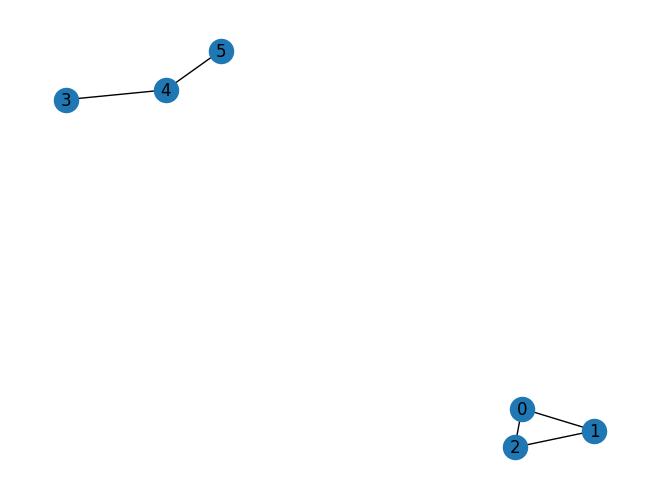

In [2]:
#creating a graph with determinated edges

G = nx.Graph()
edges = np.array([(0, 1), (0, 2), (1,2), (3, 4), (4, 5)]) #be careful, the nodes must be noted from 0 to n where n is the number of total nodes
G.add_edges_from(edges)

#setting the position of the nodes using spring_layout
pos = nx.spring_layout(G, seed = 42)#the seed can be changed, but the seed 42 is used by the Quantum_MIS class

#plot the graph
nx.draw(G, pos = pos, with_labels = True)
plt.show()

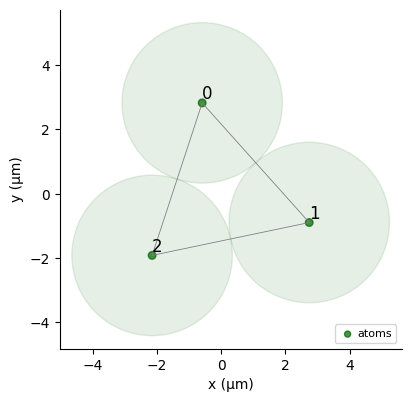

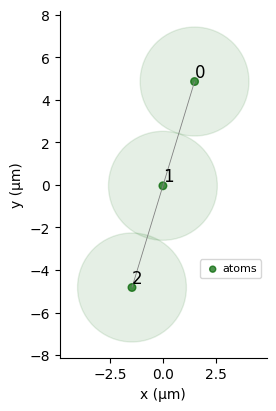

In [3]:
#creating the quantum solver object
from QMIS_code.Quantum_MIS import Quantum_MIS
from pulser.devices import AnalogDevice

#We first want to specify the device used to run the quantum_MIS algorithm 
device = AnalogDevice

#we only need to pass the graph object in the Quantum_MIS class
mis_solution = Quantum_MIS(G, device)

#the Quantum_MIS class creates a register for each connected components
# we can now print the registers created
mis_solution.print_regs() 


Now that we have created the register, we need to create a Pulse. In this project, 5 types of pulse have been implemented. 
- "Rise_sweep_fall" -> A pulse that starts to 0, rises during a quarter of the total time to the omega specified, stays constant during half of the total time, and falls to 0 during a quarter of the total time.

- "Pyramid" -> A pulse that starts at a certain value that is Omega - delta. The pulse stays at this value for a quarter of the total time, does a Rise_Fall pulse for half of the total time, and finally stays constant at Omega-delta for the last quarter of the total time.

- "Blackman" -> This pulse is a normal form with a total area of Omega with a lenght given by the time.

- "Rise_fall" -> This pulse is only the rise and fall part of the Rise_Sweep_Fall pulse. It rises during half of the time from 0 to Omega and falls back to 0 for the last half of the total time.

- "Waveform" -> This pulse starts at 0, is at Omega at half of the total time, and falls back to 0 at the end, but follows a waveform pattern instead of a linear pattern like the Rise_Fall. 

In [4]:
from QMIS_code.pulse_utils import Pulse_constructor

T = 4000 #time of the pulse in ns, the time limit is 4000.

pulse_type = "Rise_sweep_fall" #the pulse type used.

#constructing the pulse using the time and the pulse_type
pulse = Pulse_constructor(T, pulse_type)




It's now time to run the quantum_MIS algorithm. This algorithm takes a graph with all its connected components and resolves it with a quantum adiabatic algorithm and combines them to return a count dictionnary.

In [5]:
shots = 100 #the number of shots doesn't have to be this big for the results to be good

counts_results = mis_solution.run(pulse, progress_bar=False, shots = shots)
print(counts_results)

{'000001': 11, '000100': 17, '000101': 81, '001001': 41, '001100': 47, '001101': 111, '010001': 33, '010100': 39, '010101': 103, '100001': 47, '100100': 53, '100101': 117}


There's an argument in the run meethod named `generate_histogram`. Here's an exemple of the histogram it would produces:

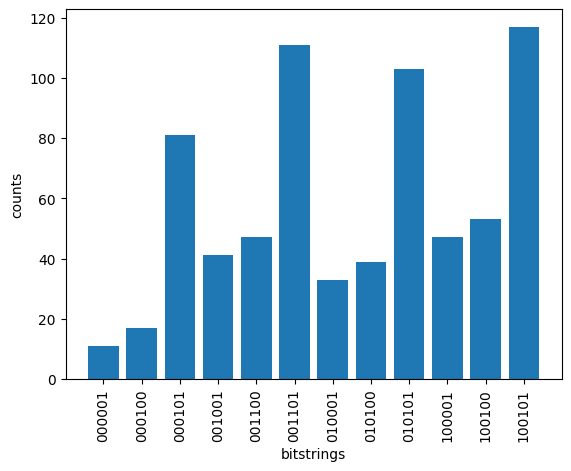

In [ ]:
from QMIS_code.QMIS_utils import plot_histogram

plot_histogram(counts_results, shots) #you can also give a file_name in argument in this function to save the histogram in your repository